# Implementing ioU metric for boxes (MC way)


In [6]:
import h5py
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import scipy
from scipy.spatial.distance import cdist
import itertools

In [37]:
def belongs_to(point, box, isdf=False):
    
    if isdf:
        center = np.array([box['X_box'], box['Y_box'], box['Z_box']])
        point = np.array([i for i in point]) - center
        anti_rotation_matrix = np.array([[np.cos(-box['angle_box']), -np.sin(-box['angle_box']), 0], 
                            [np.sin(-box['angle_box']), np.cos(-box['angle_box']), 0], 
                            [0,0,1]])
        rot_point = anti_rotation_matrix.dot(point)
        if np.abs(rot_point[0])<box['length_box']/2 and np.abs(rot_point[1])<box['width_box']/2 and np.abs(rot_point[2])<box['height_box']/2:
            return True
        return False
    
    center = np.array([i for i in box[0]])
    point = np.array([i for i in point]) - center
    anti_rotation_matrix = np.array([[np.cos(-box[4]), -np.sin(-box[4]), 0], 
                            [np.sin(-box[4]), np.cos(-box[4]), 0], 
                            [0,0,1]])
    rot_point = anti_rotation_matrix.dot(point)
    
    if np.abs(rot_point[0])<box[1]/2 and np.abs(rot_point[1])<box[2]/2 and np.abs(rot_point[2])<box[3]/2:
        return True
    return False

def compute_approx_IoU(box1, box2, attempts=1000, isdf=False):
    
    if isdf:
        pos1 = [box1['X_box'], box1['Y_box'], box1['Z_box']]
        pos2 = [box2['X_box'], box2['Y_box'], box2['Z_box']]
        length1 = box1['length_box']
        width1 = box1['width_box']
        height1 = box1['height_box']
        length2 = box2['length_box']
        width2 = box2['width_box']
        height2 = box2['height_box']
        diag1 = np.sqrt(length1**2+width1**2+height1**2)
        diag2 = np.sqrt(length2**2+width2**2+height2**2)
        rotation_matrix1 = np.array([[np.cos(box1['angle_box']), -np.sin(box1['angle_box']), 0], 
                                [np.sin(box1['angle_box']), np.cos(box1['angle_box']), 0], 
                                [0,0,1]])
        rotation_matrix2 = np.array([[np.cos(box2['angle_box']), -np.sin(box2['angle_box']), 0], 
                                [np.sin(box2['angle_box']), np.cos(box2['angle_box']), 0], 
                                [0,0,1]])
    else:    
    #box is composed of [coords_center, length, width, height, angle]
        pos1 = box1[0]
        pos2 = box2[0]
        length1 = box1[1]
        width1 = box1[2]
        height1 = box1[3]
        length2 = box2[1]
        width2 = box2[2]
        height2 = box2[3]
        diag1 = np.sqrt(length1**2+width1**2+height1**2)
        diag2 = np.sqrt(length2**2+width2**2+height2**2)
        rotation_matrix1 = np.array([[np.cos(box1[4]), -np.sin(box1[4]), 0], 
                                [np.sin(box1[4]), np.cos(box1[4]), 0], 
                                [0,0,1]])
        rotation_matrix2 = np.array([[np.cos(box2[4]), -np.sin(box2[4]), 0], 
                                [np.sin(box2[4]), np.cos(box2[4]), 0], 
                                [0,0,1]])

    if np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2+(pos1[2]-pos2[2])**2)>max(diag1, diag2):
        return 0
    intersection = 0
    for i in range(attempts):
        u = np.random.uniform(-1,1,size=3) * np.array([length1,width1,height1])/2 
        u = rotation_matrix1.dot(u)
        if belongs_to(u + np.array([i for i in pos1]), box2, isdf):
            intersection +=1
        u = np.random.uniform(-1,1,size=3) * np.array([length2,width2,height2])/2 
        u = rotation_matrix2.dot(u)
        if belongs_to(u + np.array([i for i in pos2]), box1, isdf):
            intersection +=1
   
    return intersection/2/attempts

In [8]:
hdf5data_109 = h5py.File('../../Data/data_109.h5', 'r')

In [9]:
def convert_to_image_space ( coordinates , world2cam , cam2im ):
    """ Input single set of coordinatetes """
    coord_4 = np.ones (4)
    coord_4[0:3] = coordinates
    cams_coord = ( np.matmul( world2cam , coord_4.T )).T
    cams_coord_4 = np.ones(4)
    
    cams_coord_4 [0:3] = cams_coord [0:3]
    ims_coord = ( np . matmul ( cam2im , cams_coord_4 .T )). T
    # Divide by z coordinate for some reason
    ims_coord [0] = ims_coord [0]/ ims_coord [2]
    ims_coord [1] = ims_coord [1]/ ims_coord [2]
    ims_coord = ims_coord [0:2]
    
    return ( ims_coord )

def visualize_frame_detections ( camera, frame_idx, figsize = None , s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])

    x_list = []
    y_list = []

    for point in detected_points:
    
        world_pos = np.array(point[0].tolist())
        fin_pos = convert_to_image_space(world_pos, camera['TMatrixWorldToCam'], camera['ProjectionMatrix'])
        x_list.append(fin_pos[0])
        y_list.append(fin_pos[1])

    # Show image
    a = np.asarray(frame['Image'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    plt.imshow(a, cmap = 'gist_gray', zorder = 1)
    plt.scatter(x_list, y_list, s = s, color = 'hotpink', zorder = 3)
    
    return

def visualize_frame_boxes ( camera, frame_indexes, figsize = None, s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    if figsize is not None: 
            plt.figure(figsize = figsize)
    for frame_idx in frame_indexes:
        frame = camera['Sequence'][str(frame_idx)]
        detected_points = np.asarray(frame['Detections'])

        for point in detected_points:
            # first face 
            unrotated_vertex1 = np.array([+ point['Length']/2, + point['Width']/2, + point['Height']/2])
            unrotated_vertex2 = np.array([+ point['Length']/2, + point['Width']/2, - point['Height']/2])
            unrotated_vertex3 = np.array([+ point['Length']/2, - point['Width']/2, - point['Height']/2])
            unrotated_vertex4 = np.array([+ point['Length']/2, - point['Width']/2, + point['Height']/2])
            # second face 
            unrotated_vertex5 = np.array([- point['Length']/2, + point['Width']/2, + point['Height']/2])
            unrotated_vertex6 = np.array([- point['Length']/2, + point['Width']/2, - point['Height']/2])
            unrotated_vertex7 = np.array([- point['Length']/2, - point['Width']/2, - point['Height']/2])
            unrotated_vertex8 = np.array([- point['Length']/2, - point['Width']/2, + point['Height']/2])


            unrotated_vertex_list = [unrotated_vertex1, unrotated_vertex2, unrotated_vertex3, 
                                     unrotated_vertex4, unrotated_vertex5, unrotated_vertex6, 
                                     unrotated_vertex7, unrotated_vertex8]

            rotation_matrix = np.array([[np.cos(point['Angle']), -np.sin(point['Angle']), 0], 
                                [np.sin(point['Angle']), np.cos(point['Angle']), 0], 
                                [0,0,1]])

            rotated_vertex_list = np.array([rotation_matrix.dot(v) for v in unrotated_vertex_list])
            rotated_vertex_list = rotated_vertex_list + np.array([point['Pos']['X'], point['Pos']['Y'], point['Pos']['Z']])

            vertex_im_list = [convert_to_image_space(v, camera['TMatrixWorldToCam'], camera['ProjectionMatrix']) for v in rotated_vertex_list]


            combinations = [(i,i+1) for i in range(3)] + [(3,0)] + [(i,i+1) for i in range(4,7)] + [
                (7,4)] + [(i,i+4) for i in range(4)]

            for (i,j) in combinations: 
                vertex_x_list = [vertex_im_list[i][0],vertex_im_list[j][0]]
                vertex_y_list = [vertex_im_list[i][1],vertex_im_list[j][1]]
                plt.plot(vertex_x_list, vertex_y_list, color = 'b', zorder = 2, alpha=0.5)


        
    visualize_frame_detections ( camera, frame_indexes[0], s = s )
    
    return

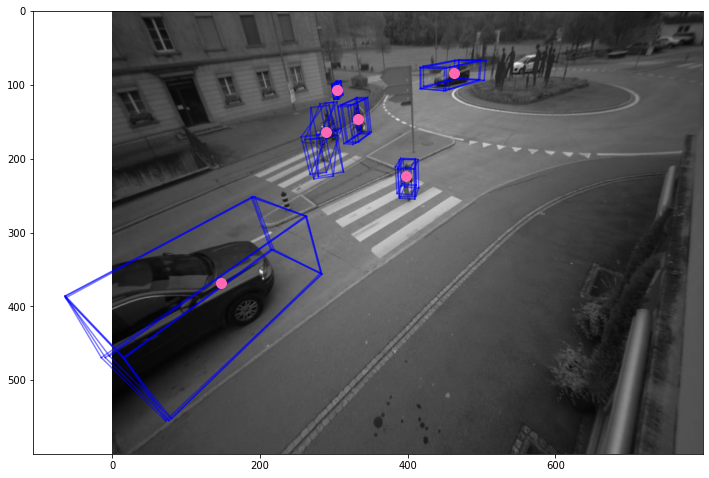

In [10]:
visualize_frame_boxes(hdf5data_109,[262, 263, 264], figsize = (12,12))

As we can see, the bounding boxes are generally disjoint and well intersecting among frames

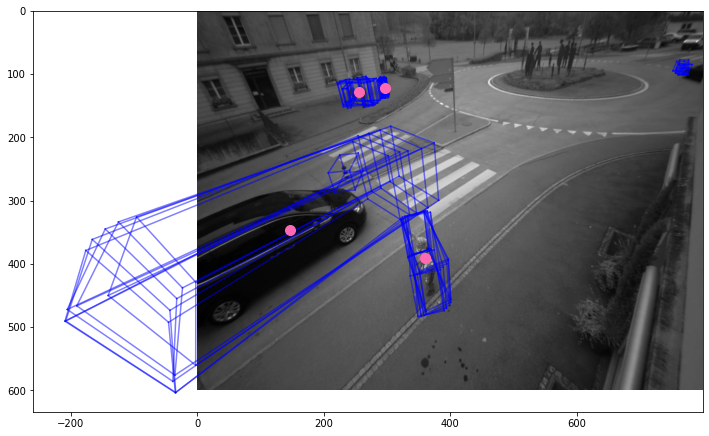

In [11]:
visualize_frame_boxes(hdf5data_109,[0,1, 2, 3,4], figsize = (12,12))

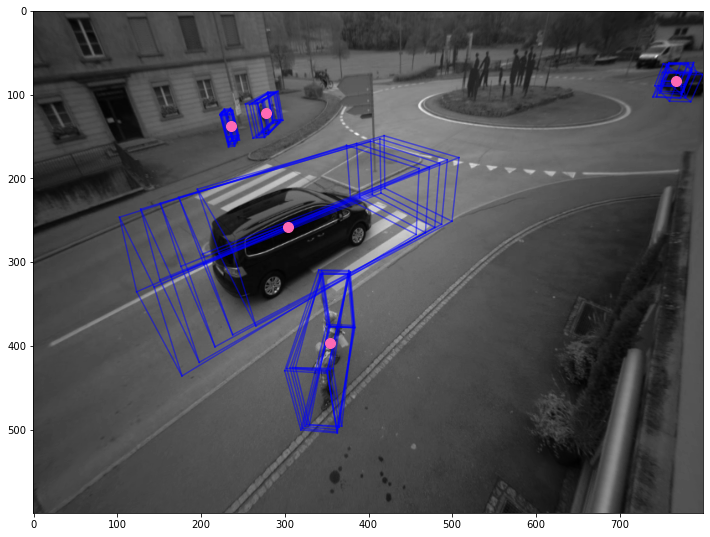

In [7]:
visualize_frame_boxes(hdf5data_109,[10, 11,12, 13,14], figsize = (12,12))

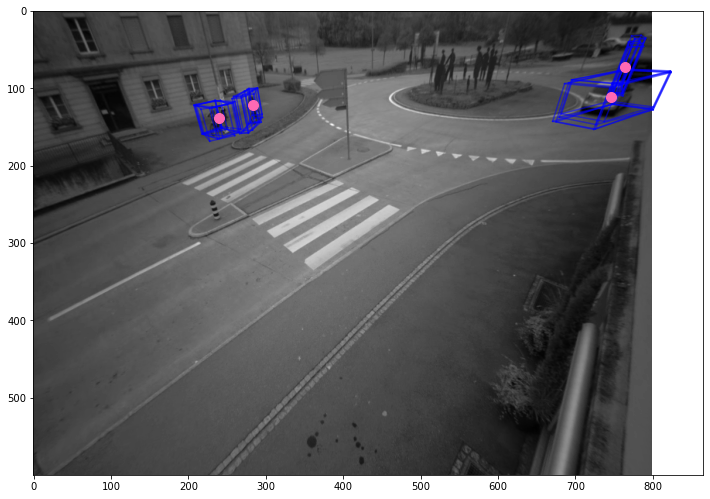

In [8]:
visualize_frame_boxes(hdf5data_109,[701, 702, 703,704], figsize = (12,12))

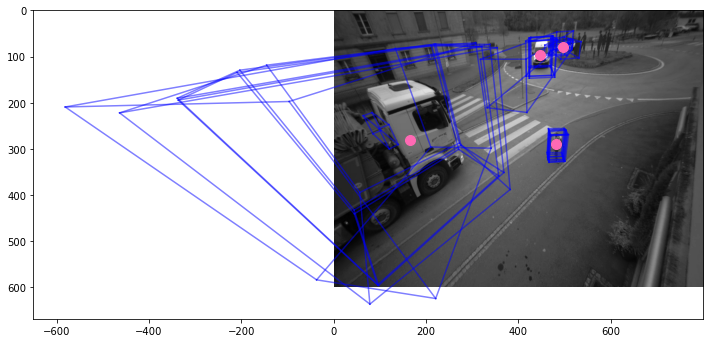

In [9]:
visualize_frame_boxes(hdf5data_109,[501, 502, 503,504], figsize = (12,12))

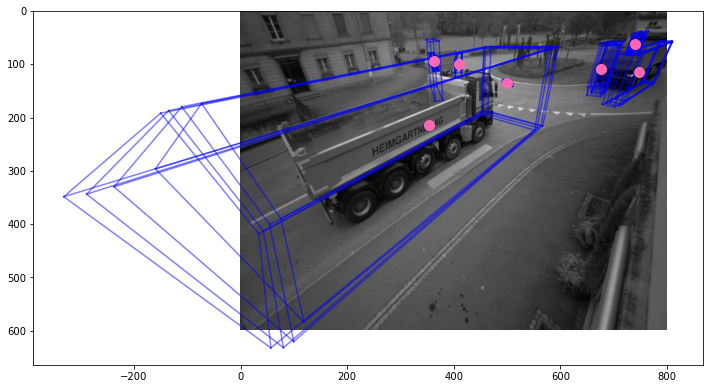

In [10]:
visualize_frame_boxes(hdf5data_109,[601, 602, 603,604], figsize = (12,12))

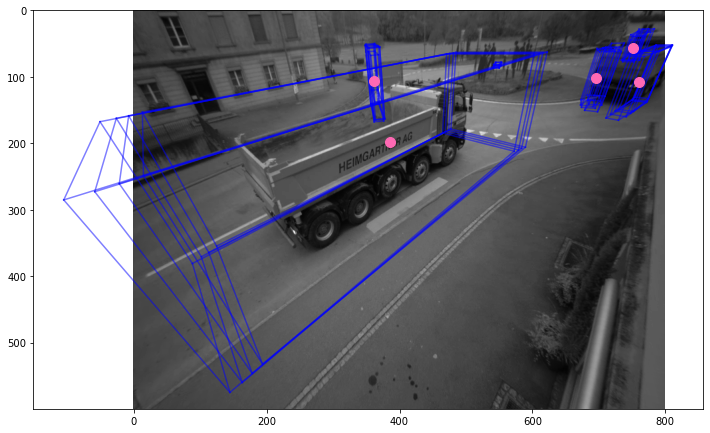

In [11]:
visualize_frame_boxes(hdf5data_109,[ 605, 606,607, 608], figsize = (12,12))

Possible problems: 

initial box is rotated in an incorrect way-> better estimate speed through second frame on (if any)

objs may have multiple boxes. In that case if it is una tantum this way you can discard it kind of safely, while if it happens frequently you might want to consider the case in which it was 2 objs and you did not see them at first



In [12]:
frame1 = hdf5data_109['Sequence']['0']['Detections']
frame2 = hdf5data_109['Sequence']['1']['Detections']


box1 = np.array(frame1)[0]
box2 = np.array(frame2)[1]

print(box1)
print(box2)

compute_approx_IoU(box1, box2,1000)

((-11.14840948, 15.36387945, -0.94192017), 1.17728508, 0.56196702, 1.33484852, 0.6319266)
((-11.13715245, 15.4159205, -0.91196762), 1.35261762, 0.54668379, 1.37023413, 0.70885205)


0.8435

In [38]:
def find_subsequent_boxes(detection1, detection2, threshold=0.2, all_matches=False, isdf=False):
    """
    Returns a list of triplets of the best matches of boxes in detection2 for boxes in detection1, if any 
    (detection being a list of boxes, i.e. tuples (coord, length, width, height, angle))
    If no IoU above a fixed threshold is found, the box is disregarded.
    Optionally it will also return all found triplets (all_matches = True)
    """
    triplets = [] # index1, index2, iou
    all_triplets = []
    for i in range(len(detection1)):
        promising = []
        best_iou = 0
        best_idx = -1
        for j in range(len(detection2)):
            
            iou = compute_approx_IoU(detection1[i],detection2[j],isdf = isdf)
            if iou > threshold: # can be refined to also account for very different volumes
                promising.append((i,j,iou))
                if iou>best_iou:
                    best_iou = iou
                    best_idx = j
        #can use this to check if there is any split, uncertainty, etc
        if(len(promising)>0):
            triplets.append((i, best_idx, best_iou))
            all_triplets[len(all_triplets):] = promising
    if all_matches:
        return triplets, all_triplets
    return triplets

In [39]:
find_subsequent_boxes(frame1, frame2)

[(0, 1, 0.8565), (1, 2, 0.702), (2, 3, 0.8825), (3, 4, 0.948)]

In [40]:
print(np.array(frame1))
print(np.array(frame2))

[((-11.14840948, 15.36387945, -0.94192017), 1.17728508, 0.56196702, 1.33484852,  0.6319266 )
 (( -9.56017321, 18.98365405, -1.37740528), 3.32599759, 0.95396274, 1.49857235, -0.12075473)
 ((  3.37372865, 28.17532326, -1.134802  ), 5.49311066, 1.93080485, 2.05683565,  1.51485991)
 ((  6.54698041, 26.31428015, -0.86229922), 1.50684786, 0.59277284, 1.13471138,  0.42430577)]
[(( 10.19346374, -3.25412106, -0.71199026), 1.41292083, 0.26612443, 0.46002537,  1.33751118)
 ((-11.13715245, 15.4159205 , -0.91196762), 1.35261762, 0.54668379, 1.37023413,  0.70885205)
 (( -9.48716828, 19.01814936, -1.40366656), 2.75162148, 1.20459998, 1.53325379, -0.50830543)
 ((  3.31402523, 27.99587973, -1.18681946), 5.75086117, 2.2795136 , 2.02555895,  1.53081763)
 ((  6.55745365, 26.32493125, -0.86363901), 1.56805146, 0.58442491, 1.16625619,  0.44249758)]


# Merged data from 4 sensors


Let us now implement the search on two subsequent frames as from the dataframe including observations from all cameras. Then we will also try to link observations from the same frame (or actually we do this first maybe).


In [41]:
#no
# import utilities from main

def fill_empty_track(detections, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_detections = np.vstack(coord_detections)
        
    length_box = [vals[1] for vals in detections]
    width_box = [vals[2] for vals in detections]
    height_box = [vals[3] for vals in detections]
    angle_box = [vals[4] for vals in detections]
    
    list_names = ["X_track", "Y_track", "Z_track", "vx_track", "vy_track", 
                  "vz_track", "track_id", "obj_type", "track_status"]
    
    returndf[list_names] = np.nan
    
    returndf["X_box"] = coord_detections[:,0]
    returndf["Y_box"] = coord_detections[:,1]
    returndf["Z_box"] = coord_detections[:,2]
    returndf["length_box"], returndf["width_box"], returndf["height_box"] = length_box, width_box, height_box
    returndf["angle_box"] = angle_box
    
    return returndf
    
def fill_empty_detection(tracks, returndf):
    
    coord_tracks = [np.array(vals[1].tolist()) for vals in tracks]   
    coord_tracks = np.vstack(coord_tracks)
        
    vel_tracks = [np.array(vals[2].tolist()) for vals in tracks]
    vel_tracks = np.vstack(vel_tracks)
        
    track_id = [vals[0].tolist() for vals in tracks]
    object_type = [vals[3] for vals in tracks]
    status_tracks = [vals[4] for vals in tracks]
        
    returndf["X_track"] = coord_tracks[:,0]
    returndf["Y_track"] = coord_tracks[:,1]
    returndf["Z_track"] = coord_tracks[:,2]

    returndf["vx_track"] = vel_tracks[:,0]
    returndf["vy_track"] = vel_tracks[:,1]
    returndf["vz_track"] = vel_tracks[:,2]

    returndf["track_id"] = track_id
    returndf["obj_type"] = object_type
    returndf["track_status"] = status_tracks
    
    list_names = ["X_box", "Y_box", "Z_box", "length_box", "width_box", 
                  "height_box", "angle_box"]
    
    returndf[list_names] = np.nan
    
    return returndf
    
def link_detections_tracks_NN(detections, tracks, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_tracks = [np.array(vals[1].tolist()) for vals in tracks]

    
    if coord_tracks and coord_detections:
        
        vel_tracks = [np.array(vals[2].tolist()) for vals in tracks]
        track_id = [vals[0].tolist() for vals in tracks]
        object_type = [vals[3] for vals in tracks]
        status_tracks = [vals[4] for vals in tracks]
    
    # for the time being, let us associate the closest bounding box, even if it is assigned more than once
    
        dists = cdist(coord_tracks, coord_detections, 'euclidean')
#     print(dists)
        associations = np.argmin(dists, axis=1)
    
        associations = associations.tolist()
        associated_detections = [detections[i] for i in associations]
        coord_detections = [coord_detections[i] for i in associations]
        length_box = [vals[1] for vals in associated_detections]
        width_box = [vals[2] for vals in associated_detections]
        height_box = [vals[3] for vals in associated_detections]
        angle_box = [vals[4] for vals in associated_detections]
    
        coord_detections = np.vstack(coord_detections)
        coord_tracks = np.vstack(coord_tracks)
        vel_tracks = np.vstack(vel_tracks)
        returndf["X_track"] = coord_tracks[:,0]
        returndf["Y_track"] = coord_tracks[:,1]
        returndf["Z_track"] = coord_tracks[:,2]

        returndf["vx_track"] = vel_tracks[:,0]
        returndf["vy_track"] = vel_tracks[:,1]
        returndf["vz_track"] = vel_tracks[:,2]
        returndf["track_id"] = track_id
        returndf["obj_type"] = object_type
        returndf["track_status"] = status_tracks
        
        returndf["X_box"] = coord_detections[:,0]
        returndf["Y_box"] = coord_detections[:,1]
        returndf["Z_box"] = coord_detections[:,2]
        returndf["length_box"] = length_box
        returndf["width_box"] = width_box
        returndf["height_box"] = height_box
        returndf["angle_box"] = angle_box

    return returndf

In [42]:
#no
def h5_to_df(h5data, camera = None):
    
    timestamps = h5data['Timestamp']
    df = pd.DataFrame()
    
    for c, t in enumerate(timestamps):
        
        append_df = pd.DataFrame()
        
        d = h5data['Sequence'][str(c)]
        track = np.asarray(d['Tracks'])
        detection = np.asarray(d['Detections'])
        
        if detection.size and track.size:
            append_df = link_detections_tracks_NN(detection, track, append_df)
        
        elif detection.size:
            fill_empty_track(detection, append_df)
        
        elif track.size:
            fill_empty_detection(track, append_df)
            
        append_df['timestamp'] = t
        append_df['frame'] = c
        
        if camera is not None:
            append_df['camera'] = camera
        
        df = df.append(append_df)
        
    return df

In [43]:
# upload data 
hdf5data_109 = h5py.File('../../Data/data_109.h5', 'r')
hdf5data_130 = h5py.File('../../Data/data_130.h5', 'r')
hdf5data_142 = h5py.File('../../Data/data_142.h5', 'r')
hdf5data_143 = h5py.File('../../Data/data_143.h5', 'r')

In [44]:
def fill_rows_detections(detections, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_detections = np.vstack(coord_detections)
        
    length_box = [vals[1] for vals in detections]
    width_box = [vals[2] for vals in detections]
    height_box = [vals[3] for vals in detections]
    angle_box = [vals[4] for vals in detections]
    
    returndf["X_box"] = coord_detections[:,0]
    returndf["Y_box"] = coord_detections[:,1]
    returndf["Z_box"] = coord_detections[:,2]
    returndf["length_box"], returndf["width_box"], returndf["height_box"] = length_box, width_box, height_box
    returndf["angle_box"] = angle_box
    
    return returndf

In [45]:
def df_detections(h5data,camera = None):
    
    timestamps = h5data['Timestamp']
    df = pd.DataFrame()
    
    for c, t in enumerate(timestamps):
        
        append_df = pd.DataFrame()
        
        d = h5data['Sequence'][str(c)]
        detection = np.asarray(d['Detections'])
        
        if detection.size:
            append_df = fill_rows_detections(detection, append_df)
            append_df['timestamp'] = t
            append_df['frame'] = c
        
            if camera is not None:
                append_df['camera'] = camera
        
            df = df.append(append_df)
    
    return df

In [46]:
df_109 = df_detections(hdf5data_109, 109)
df_109.reset_index(inplace=True, drop=True)
df_130 = df_detections(hdf5data_130, 130)
df_130.reset_index(inplace=True, drop=True)
df_142 = df_detections(hdf5data_142, 142)
df_142.reset_index(inplace=True, drop=True)
df_143 = df_detections(hdf5data_143, 143)
df_143.reset_index(inplace=True, drop=True)

In [47]:
def concatenate_dfs(dfs, sort_cols):
    
    df_to_concat = dfs
    df_complete = pd.concat(df_to_concat)
    df_complete.sort_values(by = sort_cols, inplace = True)
    df_complete.reset_index(inplace=True, drop=True)
    
    return df_complete

df_complete = concatenate_dfs([df_109,df_130,df_142,df_143] , ['frame', 'camera'])
df_complete
df_complete['elapsed_time'] = df_complete['timestamp']-df_complete['timestamp'].min()

In [48]:
print(len(np.unique(df_complete['elapsed_time'])))
print(np.min(df_complete.groupby('elapsed_time').count()))

2915
X_box         1
Y_box         1
Z_box         1
length_box    1
width_box     1
height_box    1
angle_box     1
timestamp     1
frame         1
camera        1
dtype: int64


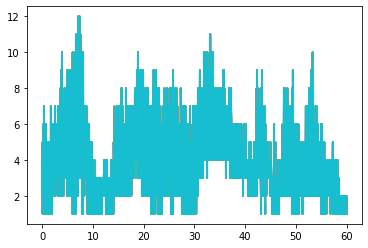

In [49]:
plt.plot(df_complete.groupby('elapsed_time').count())

In [50]:
df_complete[['elapsed_time', 'camera', 'frame']].groupby(['elapsed_time', 'camera']).first().groupby('elapsed_time').nunique()

,frame
elapsed_time,
0.000000,1
0.047386,1
0.047641,1
0.081521,1
0.087634,1
...,...
59.887670,1
59.920729,1
59.927601,1


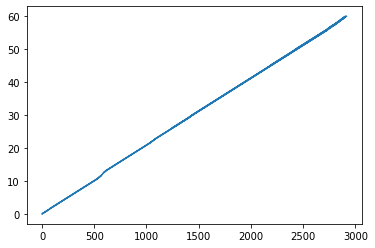

In [51]:
plt.plot(df_complete['elapsed_time'].unique())

In [52]:
df_complete.loc[df_complete['elapsed_time']==0]

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera,elapsed_time
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109,0.0
1,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109,0.0
2,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109,0.0
3,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109,0.0


In [53]:
tsmin = df_complete[['timestamp', 'camera']].groupby('camera').min()
for cam in [109, 130, 142, 143]:
    #df_complete.loc[df_complete.where('camera' == cam), columns='elapsed_time']=df_complete[['timestamp', 'camera']].loc['camera'==cam]['timestamp']-tsmin.loc['camera'==cam]['timestamp']
    df_complete.loc[df_complete['camera']==cam,'elapsed_time'] = df_complete.loc[df_complete['camera']==cam,'timestamp'] - tsmin.loc[cam,'timestamp']

In [54]:
df_complete['elapsed_time'].nunique()



2908

In [55]:
df_complete.groupby('camera')['timestamp'].apply(lambda x: x[1:]/1e5-x[:-1]/1e5)

0        NaN
1        0.0
2        0.0
3        0.0
4        NaN
        ... 
11740    NaN
11741    0.0
11742    NaN
11743    0.0
11744    NaN
Name: timestamp, Length: 11745, dtype: float64

In [ ]:
df_complete['elapsed_time'] = df_complete['timestamp']-df_complete['timestamp'].min()

In [ ]:
df_complete[['camera','elapsed_time']].groupby(['elapsed_time', 'camera']).first().reset_index().groupby('camera').diff().head(50)

In [ ]:
timediff_groups = df_complete[['camera','elapsed_time']].groupby(['elapsed_time', 'camera']).first().reset_index().groupby('camera').apply(lambda x: x.elapsed_time-x.elapsed_time.shift(1))

In [ ]:
df_time_complete = df_complete[['camera','elapsed_time', 'timestamp']].groupby(['elapsed_time', 'camera']).first().reset_index().groupby(['camera']).apply(lambda x: x.elapsed_time-x.elapsed_time.shift(1)).reset_index(name='timediff').set_index('level_1')
mergedf = df_complete[['camera','elapsed_time', 'timestamp']].groupby(['elapsed_time', 'camera']).first().reset_index()['timestamp']
df_time_complete = df_time_complete.join(mergedf)

In [ ]:
df_time_complete

In [ ]:
df_time_complete.loc[df_time_complete.groupby('camera').groups[109]]

In [ ]:
df_time_complete['camera'].unique()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
bp = timediff_groups.apply(np.log).groupby('camera').plot( ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df in df_time_complete.apply(np.log).groupby('camera'):
    bp = df.timediff.plot( ax=ax, label=label)
plt.legend()

In [ ]:
frame1 = hdf5data_109['Sequence']['0']['Detections']
frame2 = hdf5data_130['Sequence']['0']['Detections']
frame3 = hdf5data_142['Sequence']['0']['Detections']
frame4 = hdf5data_143['Sequence']['0']['Detections']

In [ ]:
visualize_frame_boxes(hdf5data_109,[0,1,2,3], figsize = (12,12))

In [ ]:
visualize_frame_boxes(hdf5data_143,[0,1,2,3], figsize = (12,12))

In [ ]:
find_subsequent_boxes(frame2, frame4) # this is the only one that finds something

In [ ]:
return_df = pd.DataFrame(columns=['camera1', 'camera2','iou', 'bestmatch1', 'bestmatch2'])
return_df = return_df.append({'camera1': 109, 'camera2': 130, 'iou': 55.3, 'bestmatch1': False, 'bestmatch2': False}, ignore_index=True)
return_df = return_df.append({'camera1': 109, 'camera2': 142, 'iou': 50.3, 'bestmatch1': False, 'bestmatch2': False}, ignore_index=True)
return_df.loc[return_df.groupby('camera1').agg(x=('iou', np.argmin))['x']]

In [20]:
def find_intersecting_boxes_df(detection1, detection2, threshold=0.2, all_matches=False):
    return_df = pd.DataFrame(columns=['camera1', 'camera2','original_idx1','original_idx2','iou', 'bestmatch1', 'bestmatch2'])
    
    for idx, det in detection1.iterrows():
        for idxx, dett in detection2.iterrows():
    
            iou = compute_approx_IoU(det,dett,isdf=True)
            if iou > threshold:
                return_df = return_df.append({'camera1': det['camera'], 'camera2': dett['camera'],'original_idx1':idx, 'original_idx2':idxx, 'iou': iou, 'bestmatch1': False, 'bestmatch2': False}, ignore_index=True)
    #print(return_df.groupby(['camera1', 'original_idx1'])['iou'].idxmin())  
    best1idx = return_df.groupby(['camera1', 'original_idx1'])['iou'].idxmin()            
    best2idx = return_df.groupby(['camera2', 'original_idx2'])['iou'].idxmin() 
    return_df.loc[best1idx, 'bestmatch1'] = True
    return_df.loc[best2idx, 'bestmatch2'] = True
    if all_matches:
        return return_df
    return return_df.loc[return_df[['bestmatch1', 'bestmatch2']].any()]

In [ ]:
d1 = df_complete.loc[np.round(df_complete['elapsed_time'],3)==0.407]
d2 = df_complete.loc[np.round(df_complete['elapsed_time'],4)==0.0815]
d2

In [ ]:
d1=df_complete.loc[9:16]
d2=df_complete.loc[16:20]

In [ ]:
find_intersecting_boxes_df(d1,d2,0.1, True)
#return_df.groupby(['camera1','idx']).agg(x=('iou', np.argmax))

In [21]:
def analyze_for_multiple_views(view_df):
    # at first we will only assume to receive the last observations for all available cameras, 
    # having already filtered out possible skipped frames
    # we will return all matches for intersection, including multiple matches 
    #(maybe one camera has a better view of the situation and sees objs as separate!)
    
    # we may also add some degree of certainty about these intersections given by position and maybe past observation (TODO)
    
    intersections_df = pd.DataFrame(columns=['camera1', 'camera2','original_idx1','original_idx2','iou', 'bestmatch1', 'bestmatch2'])
    
    # define all possible camera combinations
    cameras = view_df['camera'].unique()
    combs = list(itertools.combinations(cameras.tolist(),2))
    # find all intersecting boxes (threshold =0)
    for comb in combs:
        d1 = view_df[view_df['camera']==comb[0]]
        d2 = view_df[view_df['camera']==comb[1]]
        intersections_df = intersections_df.append(find_intersecting_boxes_df(d1,d2,0, True), ignore_index=True)
    
    return intersections_df
    

In [22]:
analyze_for_multiple_views(df_complete.loc[:9])

,camera1,camera2,original_idx1,original_idx2,iou,bestmatch1,bestmatch2
0,130.0,143.0,4,8,0.4065,True,True


In [23]:
df_complete

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera,elapsed_time
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109,0.000000
1,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109,0.000000
2,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109,0.000000
3,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109,0.000000
4,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130,0.047641
...,...,...,...,...,...,...,...,...,...,...,...
11740,-5.128264,26.316446,-1.150593,2.670343,1.157835,1.589266,-0.424405,1.574333e+09,749,109,59.920729
11741,-1.906789,-5.313489,-2.293509,3.833054,0.585950,0.395508,-0.462055,1.574333e+09,749,142,59.927601
11742,-1.142268,-3.922715,-2.524621,12.753714,0.377229,1.433762,-0.278929,1.574333e+09,749,142,59.927601
11743,14.617583,-29.436074,-1.085488,5.046473,2.802799,1.898150,-1.309933,1.574333e+09,749,143,59.967542


In [24]:
def get_all_close_frames(df, time, time_threshold=0.05):
    view_df = df[np.abs(df['elapsed_time']-time)<time_threshold]
    return analyze_for_multiple_views(view_df)

In [27]:
def get_all_cameras_intersections(df):
    res_df = pd.DataFrame()
    for elapsed_time in np.arange(0,60, 0.08):
        temp_df = get_all_close_frames(df, elapsed_time)
        temp_df['elapsed_time'] = elapsed_time
        res_df = res_df.append(temp_df, ignore_index=True)
    return res_df

In [28]:
res = get_all_cameras_intersections(df_complete)

KeyboardInterrupt: 